In [1]:
%cd ../..

/home/jnainani_umass_edu/codellm/MechInterpCodeLLMs


In [2]:
import transformer_lens

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
import os
import time
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional, Callable
from typing_extensions import Literal
from functools import partial
import copy
import itertools
import json

from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML, Markdown
from IPython import get_ipython

# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython = get_ipython()
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

/tmp/ipykernel_3673405/3715311821.py:33: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_3673405/3715311821.py:34: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [4]:
# THIS IS A LOCAL (MODIFIED) VERSION OF TRANSFORMER_LENS - UNINSTALL PIP/CONDA VERSION BEFORE USE!
import transformer_lens
import transformer_lens.utils as utils
import transformer_lens.patching as patching
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)

In [5]:
# HuggingFace bookkeeping so that the home folder doesn't get filled up
# I have these in my .bashrc and .zshrc and they work in terminal but not recognized by python for some reason
import os
from config import HF_TOKEN, HF_PATH

os.environ["HF_TOKEN"] = HF_TOKEN
os.environ["TRANSFORMERS_CACHE"] = HF_PATH
os.environ["HF_DATASETS_CACHE"] = HF_PATH
os.environ["HF_HOME"] = HF_PATH

In [6]:
# When using multiple GPUs we use GPU 0 as the primary and switch to the next when it is 90% full
num_gpus = torch.cuda.device_count()
device_id = 0
if num_gpus > 0:
    device = "cuda:0"
else:
    device = "cpu"
    
def check_gpu_memory(max_alloc=0.9):
    if not torch.cuda.is_available():
        return
    global device_id, device
    print("Primary device:", device)
    torch.cuda.empty_cache()
    max_alloc = 1 if max_alloc > 1 else max_alloc
    for gpu in range(num_gpus):
        memory_reserved = torch.cuda.memory_reserved(device=gpu)
        memory_allocated = torch.cuda.memory_allocated(device=gpu)
        total_memory = torch.cuda.get_device_properties(gpu).total_memory 
        print(f"GPU {gpu}: {total_memory / (1024**2):.2f} MB  Allocated: {memory_allocated / (1024**2):.2f} MB  Reserved: {memory_reserved / (1024**2):.2f} MB")
                
        # Check if the current GPU is getting too full, and if so we switch the primary device to the next GPU
        if memory_reserved > max_alloc * total_memory:
            if device_id < num_gpus - 1:
                device_id += 1
                device = f"cuda:{device_id}"
                print(f"Switching primary device to {device}")
            else:
                print("Cannot switch primary device, all GPUs are nearly full")

print("Number of GPUs:", num_gpus)
check_gpu_memory()

def timeit(func):
    """Decorator to measure the execution time of a function."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__!r} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

Number of GPUs: 2
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 0.00 MB  Reserved: 0.00 MB
GPU 1: 81050.62 MB  Allocated: 0.00 MB  Reserved: 0.00 MB


In [7]:
# Create transformer
model = HookedTransformer.from_pretrained("CodeLlama-7b-hf", n_devices=num_gpus)

# We need these so that individual attention heads and MLP inputs can be edited
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_attn_result(True) # Documentation says this easily burns through GPU memory

check_gpu_memory()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model CodeLlama-7b-hf into HookedTransformer
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.18 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


# Old IOI task

In [7]:
# Some examples to work with - replace with code examples

prompts = ['When J and M went to the shops, J gave the bag to ', 'When J and M went to the shops, M gave the bag to ', 'When T and J went to the park, J gave the ball to ', 'When T and J went to the park, T gave the ball to ', 'When D and S went to the shops, S gave an apple to ', 'When D and S went to the shops, D gave an apple to ', 'After R and A went to the park, A gave a drink to ', 'After R and A went to the park, R gave a drink to ']
answers = [('M', 'J'), ('J', 'M'), ('T', 'J'), ('J', 'T'), ('D', 'S'), ('S', 'D'), ('R', 'A'), ('A', 'R')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=device)
print("Answer token indices", answer_token_indices)
check_gpu_memory()

Clean string 0 <s> When J and M went to the shops, J gave the bag to 
Corrupted string 0 <s> When J and M went to the shops, M gave the bag to 
Answer token indices tensor([[341, 435],
        [435, 341],
        [323, 435],
        [435, 323],
        [360, 317],
        [317, 360],
        [390, 319],
        [319, 390]], device='cuda:0')
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26348.49 MB  Reserved: 26370.00 MB


In [8]:
print("Number of tokens in clean: ", len(clean_tokens[0]))
print("Number of tokens in corrupted: ", len(corrupted_tokens[0]))

Number of tokens in clean:  17
Number of tokens in corrupted:  17


In [9]:
# Logit difference metric
def get_logit_diff(logits, answer_token_indices=answer_token_indices, device="cpu"):
    if len(logits.shape) == 3:
        # Get final logits only
        logits = logits[:, -1, :]
    logits = logits.to(answer_token_indices.device)
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

# model.to("cpu")
print("here")
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
check_gpu_memory()
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
check_gpu_memory()

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
check_gpu_memory()

here
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 39114.84 MB  Reserved: 39222.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 51873.89 MB  Reserved: 52048.00 MB
Clean logit diff: 0.9658
Corrupted logit diff: -0.9658
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 51873.89 MB  Reserved: 52048.00 MB


# Information Retrieval

## Loading Info Retrieval Data (only 4 examples, matching IOI, maybe the quality of data will matter idk)

In [8]:
with open('data/prompt_dataset_zero_shot.json', 'r') as f:
    data = json.load(f)

# Take the first few dictionaries (e.g., first 3)
subset = data[:4]

# Initialize lists
prompts = []
answers = []

# Extract prompts and outputs
outputs = []
for ind, item in enumerate(subset):
    # if ind in [0, 1, 3, 4, 5, 6, 7, 9]:
    prompts.append(item["prompt"])
    outputs.append(item["output"])

# Group pairs of outputs and reverse the tuples alternately
for i in range(0, len(outputs) - 1, 2):
    answers.append((outputs[i], outputs[i + 1]))
    answers.append((outputs[i + 1], outputs[i]))

# Display the results
print("Prompts:", prompts)
print("Answers:", answers)

Prompts: ["def K(a, b):\n    return a - b\ndef F(a, b):\n    return a * b\ndef G(a, b):\n    return a + b\ndef I(a, b):\n    return a < b\n\nthe name of the function that uses the '-' operator is ", "def K(a, b):\n    return a - b\ndef F(a, b):\n    return a * b\ndef G(a, b):\n    return a + b\ndef I(a, b):\n    return a < b\n\nthe name of the function that uses the '<' operator is ", "def K(a, b):\n    return a - b\ndef F(a, b):\n    return a * b\ndef G(a, b):\n    return a + b\ndef I(a, b):\n    return a < b\n\nthe name of the function that uses the '*' operator is ", "def K(a, b):\n    return a - b\ndef F(a, b):\n    return a * b\ndef G(a, b):\n    return a + b\ndef I(a, b):\n    return a < b\n\nthe name of the function that uses the '+' operator is "]
Answers: [('K', 'I'), ('I', 'K'), ('F', 'G'), ('G', 'F')]


## Generating clean and corrupted tokens

In [9]:
clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))
check_gpu_memory()

Clean string 0 <s> def K(a, b):
    return a - b
def F(a, b):
    return a * b
def G(a, b):
    return a + b
def I(a, b):
    return a < b

the name of the function that uses the '-' operator is </s>
Corrupted string 0 <s> def K(a, b):
    return a - b
def F(a, b):
    return a * b
def G(a, b):
    return a + b
def I(a, b):
    return a < b

the name of the function that uses the '<' operator is </s>
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.18 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


In [10]:
answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=device)
print("Answer token indices", answer_token_indices)
check_gpu_memory()

Answer token indices tensor([[476, 306],
        [306, 476],
        [383, 402],
        [402, 383]], device='cuda:0')
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.19 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


In [11]:
print("Number of tokens in clean: ", len(clean_tokens[0]))
print("Number of tokens in corrupted: ", len(corrupted_tokens[0]))

Number of tokens in clean:  72
Number of tokens in corrupted:  72


In [12]:
model.to_string(clean_tokens[0][66])

"'-"

# Prompt by Prompt Script

## Here are the dataset sizes before

In [12]:
print("answer shape: ", answer_token_indices.shape)
print(f"Clean token shape: {len(clean_tokens)} * {len(clean_tokens[0])}")
print(f"Corrupted token shape: {len(corrupted_tokens)} * {len(corrupted_tokens[0])}")

answer shape:  torch.Size([4, 2])
Clean token shape: 4 * 72
Corrupted token shape: 4 * 72


the above sizes are in the format of N * P, N -> number of prompts, P -> number of tokens in each prompt
Our goal is to do all memory intensive stuff one prompt at a time

# Helper functions (so we can focus on running step by step)

In [13]:
# Logit difference metric
def get_logit_diff(logits, answer_token_indices=answer_token_indices, device="cpu"):
    if len(logits.shape) == 3:
        # Get final logits only
        logits = logits[:, -1, :]
    logits = logits.to(answer_token_indices.device)
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

@timeit
def get_cache_fwd_and_bwd(model, tokens, metric, answer_indices):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")
    grad_cache = {}

    def backward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        grad_cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")
    
    result = model(tokens).to(device)
    torch.cuda.empty_cache()
    value = metric(result, answer_indices)
    value.backward()

    # Reset hooks and clear unused GPU memory
    value = value.item()
    model.reset_hooks()
    torch.cuda.empty_cache()
    
    cache = ActivationCache(cache, model).to(device)
    grad_cache = ActivationCache(grad_cache, model).to(device)
    
    return value, cache, grad_cache

@timeit
def create_attention_attr(
    clean_cache, clean_grad_cache, device
) -> TT["batch", "layer", "head_index", "dest", "src"]:
    attention_stack = torch.stack(
        [clean_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_grad_stack = torch.stack(
        [clean_grad_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_attr = attention_grad_stack * attention_stack
    attention_attr = einops.rearrange(
        attention_attr,
        "layer batch head_index dest src -> batch layer head_index dest src",
    )
    return attention_attr

@timeit
def attr_patch_residual(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device,
) -> TT["component", "pos"]:
    clean_residual, residual_labels = clean_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=True
    )
    corrupted_residual = corrupted_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    corrupted_grad_residual = corrupted_grad_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    residual_attr = einops.reduce(
        corrupted_grad_residual * (clean_residual - corrupted_residual),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return residual_attr, residual_labels

@timeit
def attr_patch_layer_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    clean_layer_out, labels = clean_cache.decompose_resid(-1, return_labels=True)
    corrupted_layer_out = corrupted_cache.decompose_resid(-1, return_labels=False)
    corrupted_grad_layer_out = corrupted_grad_cache.decompose_resid(
        -1, return_labels=False
    )
    layer_out_attr = einops.reduce(
        corrupted_grad_layer_out * (clean_layer_out - corrupted_layer_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return layer_out_attr, labels

@timeit
def attr_patch_head_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_out = clean_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_head_out = corrupted_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_grad_head_out = corrupted_grad_cache.stack_head_results(
        -1, return_labels=False
    ).to(device)
    head_out_attr = einops.reduce(
        corrupted_grad_head_out * (clean_head_out - corrupted_head_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return head_out_attr, labels

def stack_head_vector_from_cache(
    cache, activation_name: Literal["q", "k", "v", "z"], device
) -> TT["layer_and_head_index", "batch", "pos", "d_head"]:
    """Stacks the head vectors from the cache from a specific activation (key, query, value or mixed_value (z)) into a single tensor."""
    stacked_head_vectors = torch.stack(
        [cache[activation_name, l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_vectors = einops.rearrange(
        stacked_head_vectors,
        "layer batch pos head_index d_head -> (layer head_index) batch pos d_head",
    ).to(device)
    return stacked_head_vectors

@timeit
def attr_patch_head_vector(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    activation_name: Literal["q", "k", "v", "z"],
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_vector = stack_head_vector_from_cache(clean_cache, activation_name, "cpu").to(device)
    corrupted_head_vector = stack_head_vector_from_cache(
        corrupted_cache, activation_name, "cpu"
    ).to(device)
    corrupted_grad_head_vector = stack_head_vector_from_cache(
        corrupted_grad_cache, activation_name, "cpu"
    ).to(device)
    head_vector_attr = einops.reduce(
        corrupted_grad_head_vector * (clean_head_vector - corrupted_head_vector),
        "component batch pos d_head -> component pos",
        "sum",
    )
    return head_vector_attr, labels

def stack_head_pattern_from_cache(
    cache,
    device
) -> TT["layer_and_head_index", "batch", "dest_pos", "src_pos"]:
    """Stacks the head patterns from the cache into a single tensor."""
    stacked_head_pattern = torch.stack(
        [cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_pattern = einops.rearrange(
        stacked_head_pattern,
        "layer batch head_index dest_pos src_pos -> (layer head_index) batch dest_pos src_pos",
    ).to(device)
    return stacked_head_pattern

@timeit
def attr_patch_head_pattern(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "dest_pos", "src_pos"]:
    labels = HEAD_NAMES

    clean_head_pattern = stack_head_pattern_from_cache(clean_cache, "cpu").to(device)
    corrupted_head_pattern = stack_head_pattern_from_cache(corrupted_cache, "cpu").to(device)
    corrupted_grad_head_pattern = stack_head_pattern_from_cache(corrupted_grad_cache, "cpu").to(device)
    head_pattern_attr = einops.reduce(
        corrupted_grad_head_pattern * (clean_head_pattern - corrupted_head_pattern),
        "component batch dest_pos src_pos -> component dest_pos src_pos",
        "sum",
    ).to(device)
    return head_pattern_attr, labels

def get_head_vector_grad_input_from_grad_cache(
    grad_cache: ActivationCache, activation_name: Literal["q", "k", "v"], layer: int, device
) -> TT["batch", "pos", "head_index", "d_model"]:
    vector_grad = grad_cache[activation_name, layer].to(device)
    ln_scales = grad_cache["scale", layer, "ln1"].to(device)
    attn_layer_object = model.blocks[layer].attn
    if activation_name == "q":
        W = attn_layer_object.W_Q.to(device)
    elif activation_name == "k":
        W = attn_layer_object.W_K.to(device)
    elif activation_name == "v":
        W = attn_layer_object.W_V.to(device)
    else:
        raise ValueError("Invalid activation name")

    # Original notebook used (batch pos) for second input but that seems to be wrong - double check this computation
    return einsum(
        "batch pos head_index d_head, batch pos head_index, head_index d_model d_head -> batch pos head_index d_model",
        vector_grad,
        ln_scales.squeeze(-1),
        W,
    )

def get_stacked_head_vector_grad_input(
    grad_cache, activation_name: Literal["q", "k", "v"], device
) -> TT["layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_head_vector_grad_input_from_grad_cache(grad_cache, activation_name, l, "cpu")
            for l in range(model.cfg.n_layers)
        ],
        dim=0,
    ).to(device)

def get_full_vector_grad_input(
    grad_cache, device
) -> TT["qkv", "layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack([get_stacked_head_vector_grad_input(grad_cache, activation_name, "cpu").to(device) for activation_name in ["q", "k", "v"]], dim=0).to(device)

@timeit
def attr_patch_head_path(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["qkv", "dest_component", "src_component", "pos"]:
    """
    Computes the attribution patch along the path between each pair of heads.

    Sets this to zero for the path from any late head to any early head

    """
    start_labels = HEAD_NAMES
    end_labels = HEAD_NAMES_QKV
    full_vector_grad_input = get_full_vector_grad_input(corrupted_grad_cache, "cpu")
    clean_head_result_stack = clean_cache.stack_head_results(-1)
    corrupted_head_result_stack = corrupted_cache.stack_head_results(-1)
    diff_head_result = einops.rearrange(
        clean_head_result_stack - corrupted_head_result_stack,
        "(layer head_index) batch pos d_model -> layer batch pos head_index d_model",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    path_attr = einsum(
        "qkv layer_end batch pos head_end d_model, layer_start batch pos head_start d_model -> qkv layer_end head_end layer_start head_start pos",
        full_vector_grad_input,
        diff_head_result,
    )
    correct_layer_order_mask = (
        torch.arange(model.cfg.n_layers)[None, :, None, None, None, None]
        > torch.arange(model.cfg.n_layers)[None, None, None, :, None, None]
    ).to(path_attr.device)
    zero = torch.zeros(1, device=path_attr.device)
    path_attr = torch.where(correct_layer_order_mask, path_attr, zero)

    path_attr = einops.rearrange(
        path_attr,
        "qkv layer_end head_end layer_start head_start pos -> (layer_end head_end qkv) (layer_start head_start) pos",
    )
    return path_attr, end_labels, start_labels



def run_with_cache_single(model, tokens):
    logits, cache = model.run_with_cache(tokens)
    return logits.to("cpu"), cache.to("cpu")

def get_cache_fwd_and_bwd_single(model, tokens, metric_fn):
    value, cache, grad_cache = get_cache_fwd_and_bwd(model, tokens, metric_fn)
    return value, cache.to('cpu'), grad_cache.to('cpu')

## Seq processing

In [14]:
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.19 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


In [15]:
# del clean_logits
# del corrupted_logits
# del clean_logit_diff 
# del corrupted_logit_diff
# del clean_cache
# del corrupted_cache

# Empty CUDA cache
torch.cuda.empty_cache()

# Optionally check memory to confirm
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.19 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


### Initial caching for finding Clean and Corrupted Baseline ( run once, find baselines, substitute values, and comment it)
This cell caches activations one prompt at a time and concatenates at the end

In [ ]:
clean_first_logits, all_clean_caches = model.run_with_cache(clean_tokens[0:1])
all_clean_caches = all_clean_caches.to("cpu") 
clean_first_logits = clean_first_logits.to("cpu")
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 15817.34 MB  Reserved: 15964.00 MB
GPU 1: 81050.62 MB  Allocated: 15819.71 MB  Reserved: 15964.00 MB


In [17]:
corr_first_logits, all_corrupted_caches = model.run_with_cache(corrupted_tokens[0:1])
all_corrupted_caches = all_corrupted_caches.to("cpu") 
corr_first_logits = corr_first_logits.to("cpu")
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 18451.27 MB  Reserved: 18596.00 MB
GPU 1: 81050.62 MB  Allocated: 18457.30 MB  Reserved: 18596.00 MB


In [18]:

import gc

# Initializing list 
all_clean_logits = [clean_first_logits]
all_corrupted_logits = [corr_first_logits]

clean_first_logits = None
corr_first_logits = None
torch.cuda.empty_cache()
gc.collect()

check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 18451.27 MB  Reserved: 18596.00 MB
GPU 1: 81050.62 MB  Allocated: 18457.30 MB  Reserved: 18596.00 MB


In [19]:

for i in range(1, len(clean_tokens)):
    
    single_clean_tokens = clean_tokens[i:i+1]
    single_corrupted_tokens = corrupted_tokens[i:i+1]
    single_answer_token_indices = answer_token_indices[i:i+1]
    
    # print(f"Processing {i}th prompt")
    clean_logits, clean_cache = model.run_with_cache(single_clean_tokens)  
    clean_logits = clean_logits.to("cpu") 
    clean_cache = clean_cache.to("cpu")
    check_gpu_memory()
    
    all_clean_logits.append(clean_logits)
    clean_logits = None
    all_clean_caches = all_clean_caches.concatenate(clean_cache).to("cpu")
    clean_cache = None
    torch.cuda.empty_cache()
    gc.collect()

    # Process corrupted tokens
    corrupted_logits, corrupted_cache = model.run_with_cache(single_corrupted_tokens) 
    corrupted_logits = corrupted_logits.to("cpu") 
    corrupted_cache = corrupted_cache.to("cpu")
    
    check_gpu_memory()
    
    all_corrupted_logits.append(corrupted_logits)
    corrupted_logits = None
    all_corrupted_caches = all_corrupted_caches.concatenate(corrupted_cache).to("cpu")
    corrupted_cache = None
    torch.cuda.empty_cache()
    gc.collect()
    

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 21085.51 MB  Reserved: 21232.00 MB
GPU 1: 81050.62 MB  Allocated: 21096.94 MB  Reserved: 21232.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 23723.39 MB  Reserved: 23868.00 MB
GPU 1: 81050.62 MB  Allocated: 23733.39 MB  Reserved: 23884.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26362.82 MB  Reserved: 26504.00 MB
GPU 1: 81050.62 MB  Allocated: 26372.68 MB  Reserved: 26520.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 28999.09 MB  Reserved: 29156.00 MB
GPU 1: 81050.62 MB  Allocated: 29013.13 MB  Reserved: 29156.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 31637.08 MB  Reserved: 31788.00 MB
GPU 1: 81050.62 MB  Allocated: 31653.79 MB  Reserved: 31808.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34272.34 MB  Reserved: 34420.00 MB
GPU 1: 81050.62 MB  Allocated: 34296.03 MB  Reserved: 34444.00 MB


In [20]:
final_clean_logits = torch.cat(all_clean_logits, dim=0).to("cpu")
final_corrupted_logits = torch.cat(all_corrupted_logits, dim=0).to("cpu")

# Test if shapes worked
print("logits shape: ,", final_clean_logits.shape, final_corrupted_logits.shape)
print("cache shape: ,", all_corrupted_caches["hook_embed"].shape)
check_gpu_memory()

logits shape: , torch.Size([4, 72, 32016]) torch.Size([4, 72, 32016])
cache shape: , torch.Size([4, 72, 4096])
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34272.34 MB  Reserved: 34420.00 MB
GPU 1: 81050.62 MB  Allocated: 34296.03 MB  Reserved: 34444.00 MB


In [21]:
final_clean_logits = None
all_corrupted_caches = None
final_corrupted_logits = None
all_clean_caches = None
torch.cuda.empty_cache()
gc.collect()
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34272.34 MB  Reserved: 34420.00 MB
GPU 1: 81050.62 MB  Allocated: 34296.03 MB  Reserved: 34444.00 MB


In [ ]:
# first prompt processing 




    


logits shape: , torch.Size([4, 72, 32016]) torch.Size([4, 72, 32016])
cache shape: , torch.Size([4, 72, 4096])
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34269.31 MB  Reserved: 34416.00 MB
GPU 1: 81050.62 MB  Allocated: 34295.41 MB  Reserved: 34440.00 MB


In [17]:
clean_logit_diff = get_logit_diff(final_clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(final_corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
check_gpu_memory()

Clean logit diff: 0.9814
Corrupted logit diff: -0.9814
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34269.31 MB  Reserved: 34416.00 MB
GPU 1: 81050.62 MB  Allocated: 34295.41 MB  Reserved: 34440.00 MB


In [13]:
CLEAN_BASELINE = 0.9814  #clean_logit_diff
CORRUPTED_BASELINE = -0.9814  #corrupted_logit_diff

def ioi_metric(logits, answer_token_indices=answer_token_indices):
    logits = logits.to(device)
    torch.cuda.empty_cache()
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )

# print(f"Clean Baseline is 1: {ioi_metric(final_clean_logits).item():.4f}")
# print(f"Corrupted Baseline is 0: {ioi_metric(final_corrupted_logits).item():.4f}")
# check_gpu_memory()

Just remove previous cache cause memory sucks

In [14]:
# Delete tensors
# del final_clean_logits
# del final_corrupted_logits
# del clean_logit_diff 
# del corrupted_logit_diff
# all_clean_caches = all_clean_caches.to("cpu") 
# del all_corrupted_caches


# Empty CUDA cache
torch.cuda.empty_cache()

# Optionally check memory to confirm
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13174.19 MB  Reserved: 13194.00 MB
GPU 1: 81050.62 MB  Allocated: 13174.30 MB  Reserved: 13194.00 MB


## Seq forward and backward passes (please work I beg)

In [17]:
# first prompt processing 
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]
filter_not_qkv_input = lambda name: "_input" not in name

answer_token_indices_first = answer_token_indices[0:1]
clean_value, clean_cache_first, clean_grad_cache_first = get_cache_fwd_and_bwd(model, clean_tokens[0:1], ioi_metric, answer_token_indices_first)
clean_cache_first = clean_cache_first.to('cpu')
clean_grad_cache_first = clean_grad_cache_first.to('cpu')
check_gpu_memory()

corrupted_value, corrupted_cache_first, corrupted_grad_cache_first = get_cache_fwd_and_bwd(model, corrupted_tokens[0:1], ioi_metric, answer_token_indices_first)
corrupted_cache_first = corrupted_cache_first.to('cpu')
corrupted_grad_cache_first = corrupted_grad_cache_first.to('cpu')
check_gpu_memory()

for i in range(1, len(clean_tokens)):
    
    single_clean_tokens = clean_tokens[i:i+1]
    single_corrupted_tokens = corrupted_tokens[i:i+1]
    single_answer_token_indices = answer_token_indices[i:i+1]
    
    
    clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, single_clean_tokens, ioi_metric, single_answer_token_indices)
    clean_cache = clean_cache.to('cpu')
    clean_grad_cache = clean_grad_cache.to('cpu')
    clean_cache_first = clean_cache_first.concatenate(clean_cache)
    clean_grad_cache_first = clean_grad_cache_first.concatenate(clean_grad_cache)

    check_gpu_memory()
    
    
    corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, single_corrupted_tokens, ioi_metric, single_answer_token_indices)
    corrupted_cache = corrupted_cache.to('cpu')
    corrupted_grad_cache = corrupted_grad_cache.to('cpu')
    corrupted_cache_first = corrupted_cache_first.concatenate(corrupted_cache)
    corrupted_grad_cache_first = corrupted_grad_cache_first.concatenate(corrupted_grad_cache)

    check_gpu_memory()

torch.cuda.empty_cache()

# Test if shapes worked
print("cache shape: ,", corrupted_cache_first["hook_embed"].shape)
check_gpu_memory()

Function 'get_cache_fwd_and_bwd' executed in 2.1111 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 29687.88 MB  Reserved: 30154.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB
Function 'get_cache_fwd_and_bwd' executed in 2.1538 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB
Function 'get_cache_fwd_and_bwd' executed in 2.0729 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB
Function 'get_cache_fwd_and_bwd' executed in 2.0604 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB
Function 'get_cache_fwd_and_bwd' executed in 2.2644 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 261

In [ ]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

## Residual Patching

In [18]:
residual_attr, residual_labels = attr_patch_residual(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_residual' executed in 0.0578 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB


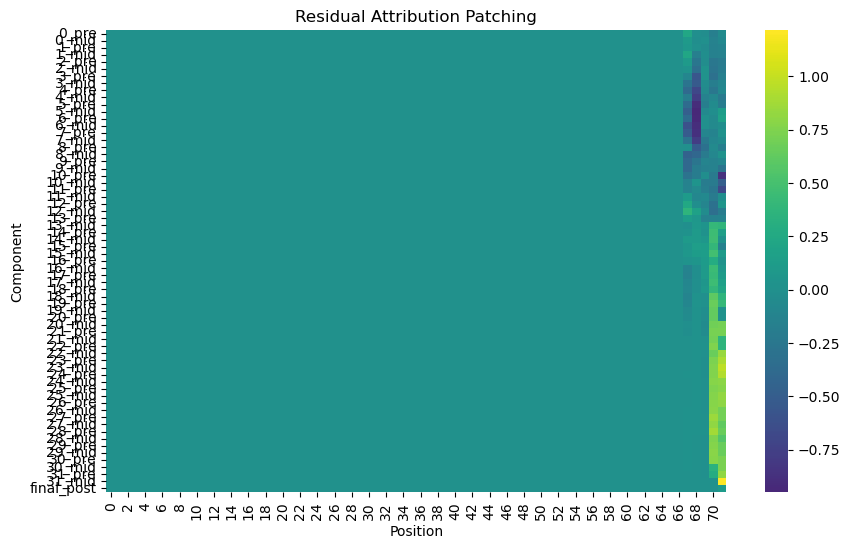

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residual_attr.detach().numpy(), yticklabels=residual_labels, annot=False, cmap='viridis', center=0)

plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Residual Attribution Patching')
plt.show()

## Layer output patching

In [22]:
layer_out_attr, layer_out_labels = attr_patch_layer_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_layer_out' executed in 0.0925 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB


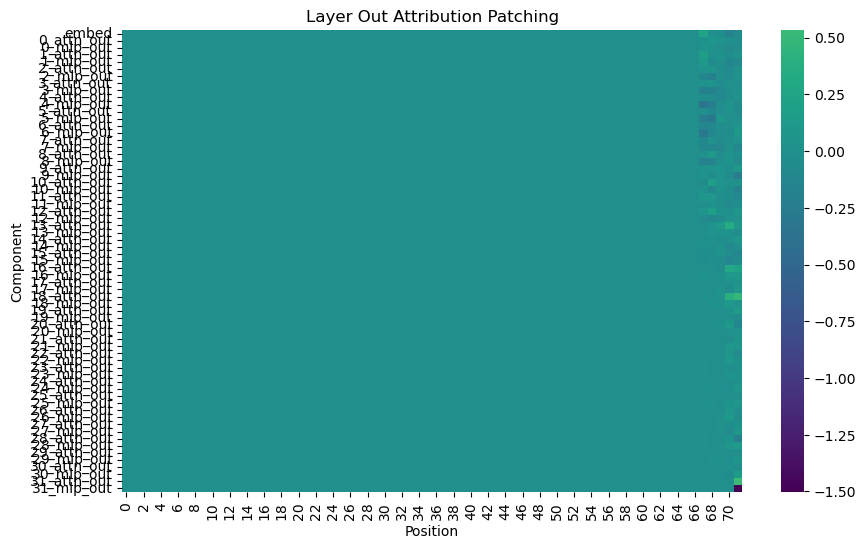

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(layer_out_attr.detach().numpy(), yticklabels=layer_out_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Layer Out Attribution Patching')
plt.show()

## Head output Attribution

In [27]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
check_gpu_memory()

['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']
Function 'attr_patch_head_out' executed in 1.5122 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB


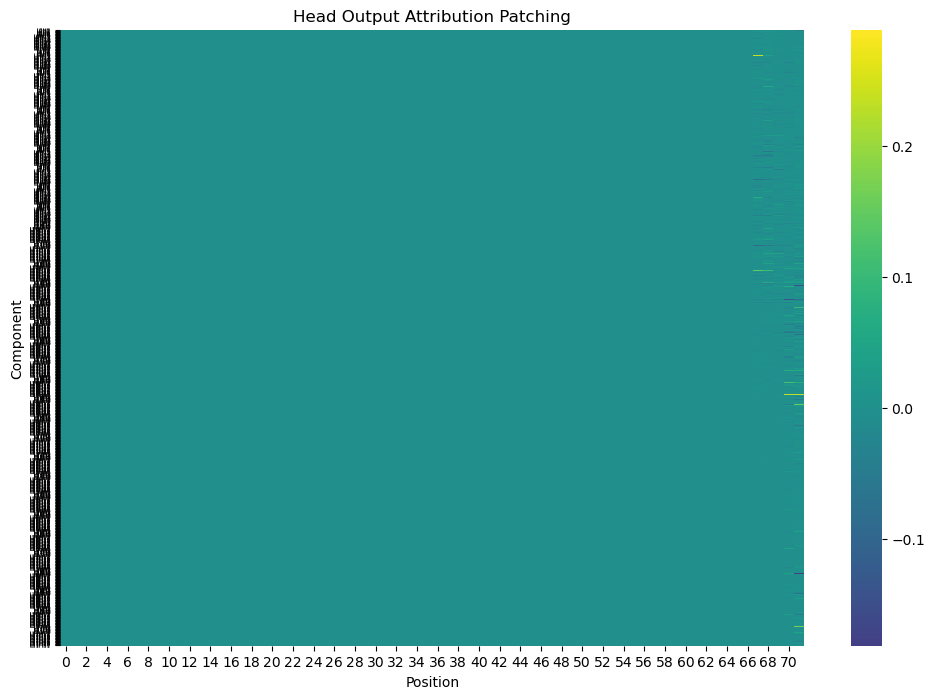

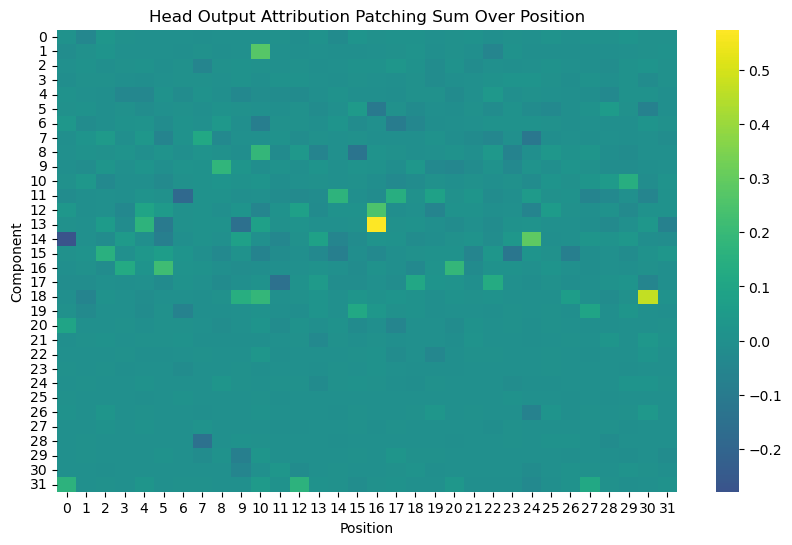

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(head_out_attr.detach().numpy(), yticklabels=head_out_labels, annot=False, cmap='viridis', center=0)
plt.yticks(fontsize = 4)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(sum_head_out_attr.detach().numpy(), annot=False, cmap='viridis', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching Sum Over Position')
plt.show()

## Head Pattern Attribution

In [ ]:
head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

head_pattern_attr = einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()

## Head path attribution 

In [33]:
head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

Function 'attr_patch_head_path' executed in 14.0082 seconds


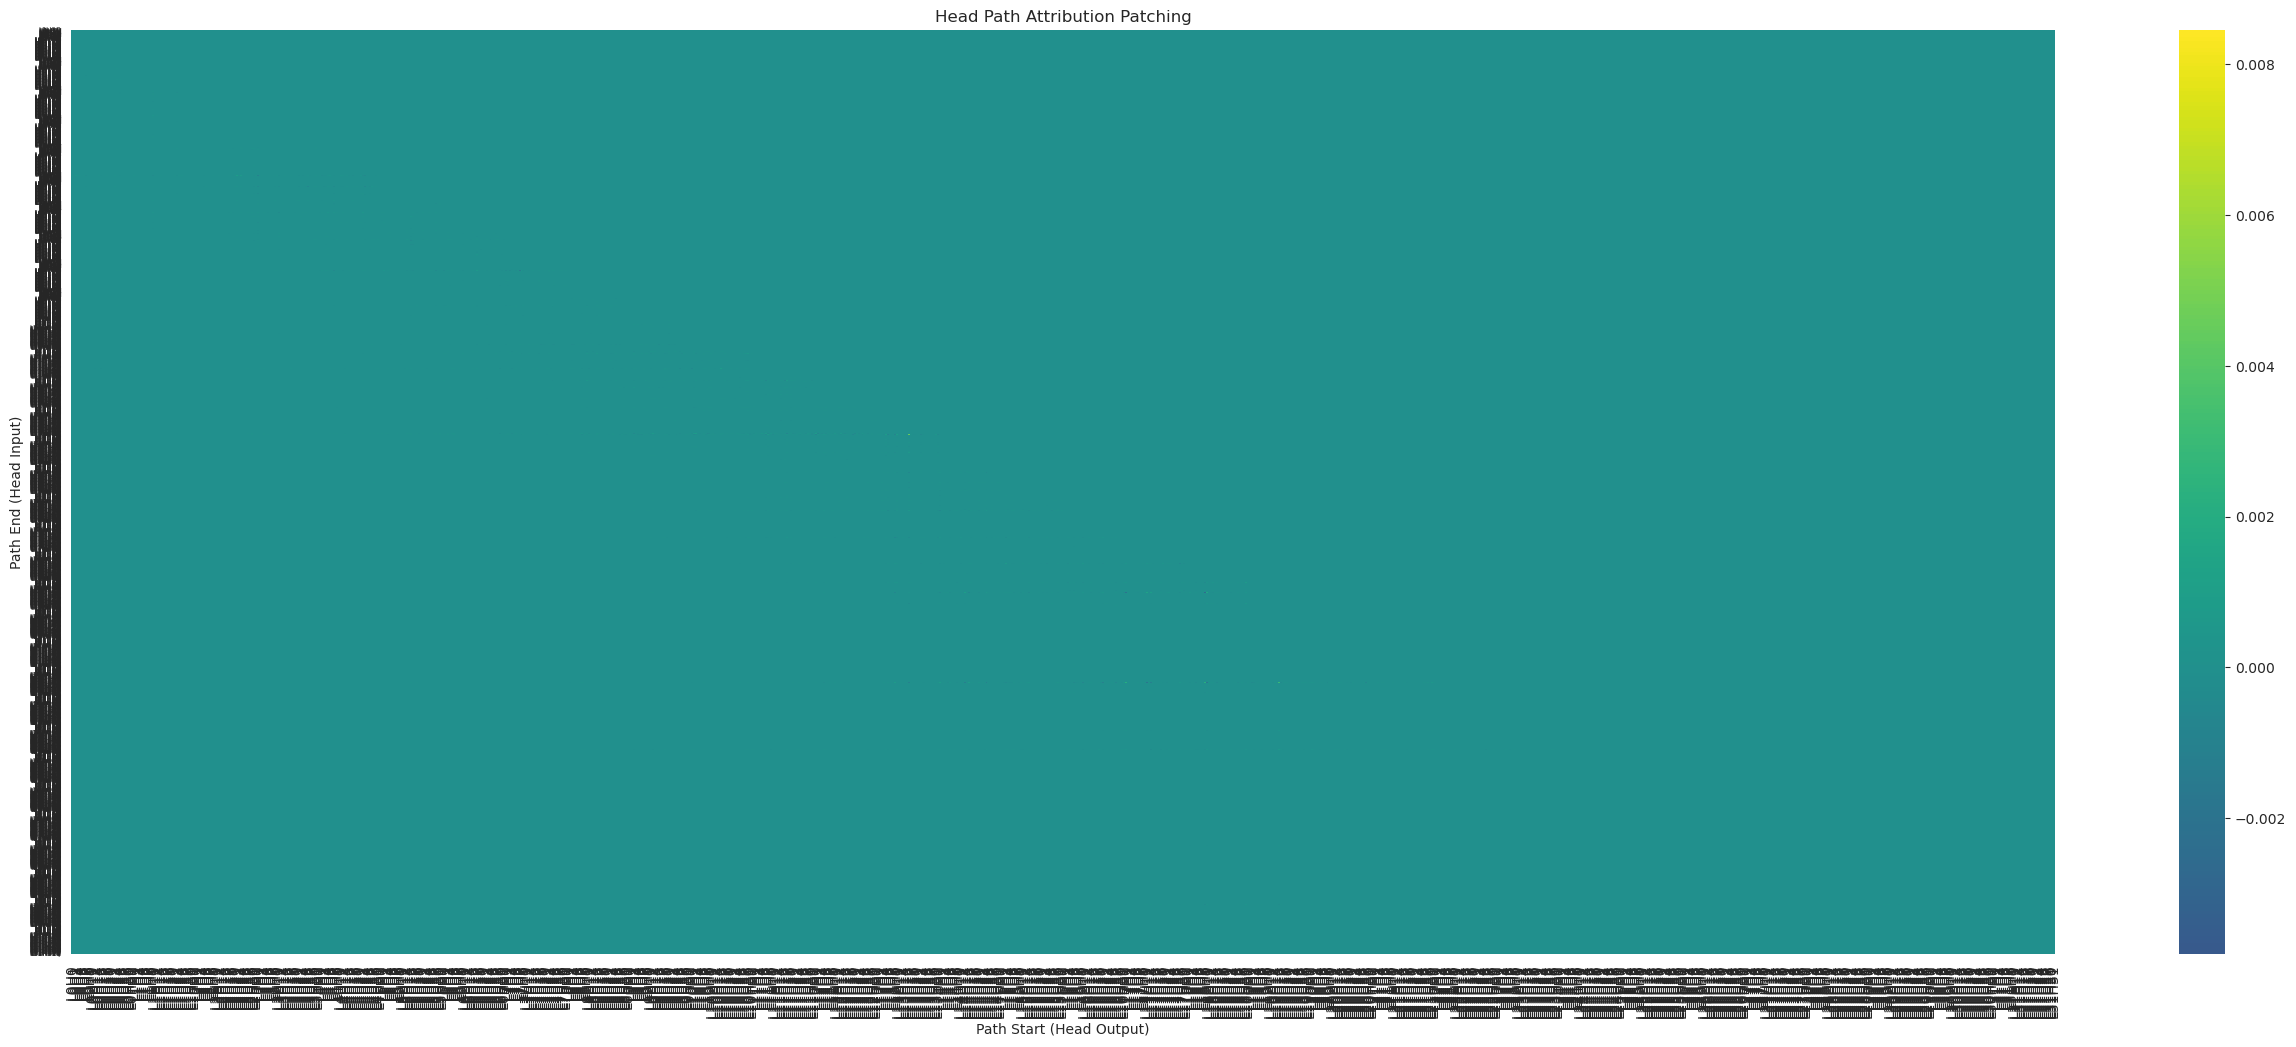

In [35]:
# TODO : viz corresponding to attr_patch_head_path

plt.figure(figsize=(32, 12))
sns.set_style("white")
sns.heatmap(head_path_attr.sum(-1).detach().numpy(), yticklabels=end_labels, xticklabels = start_labels, annot=False, cmap='viridis', center=0)
plt.yticks(fontsize = 5)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
plt.show()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26116.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26088.00 MB


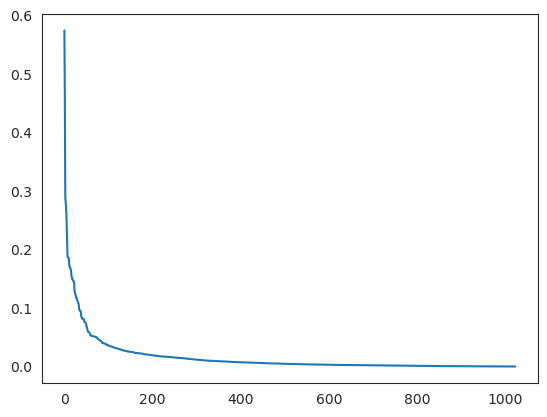

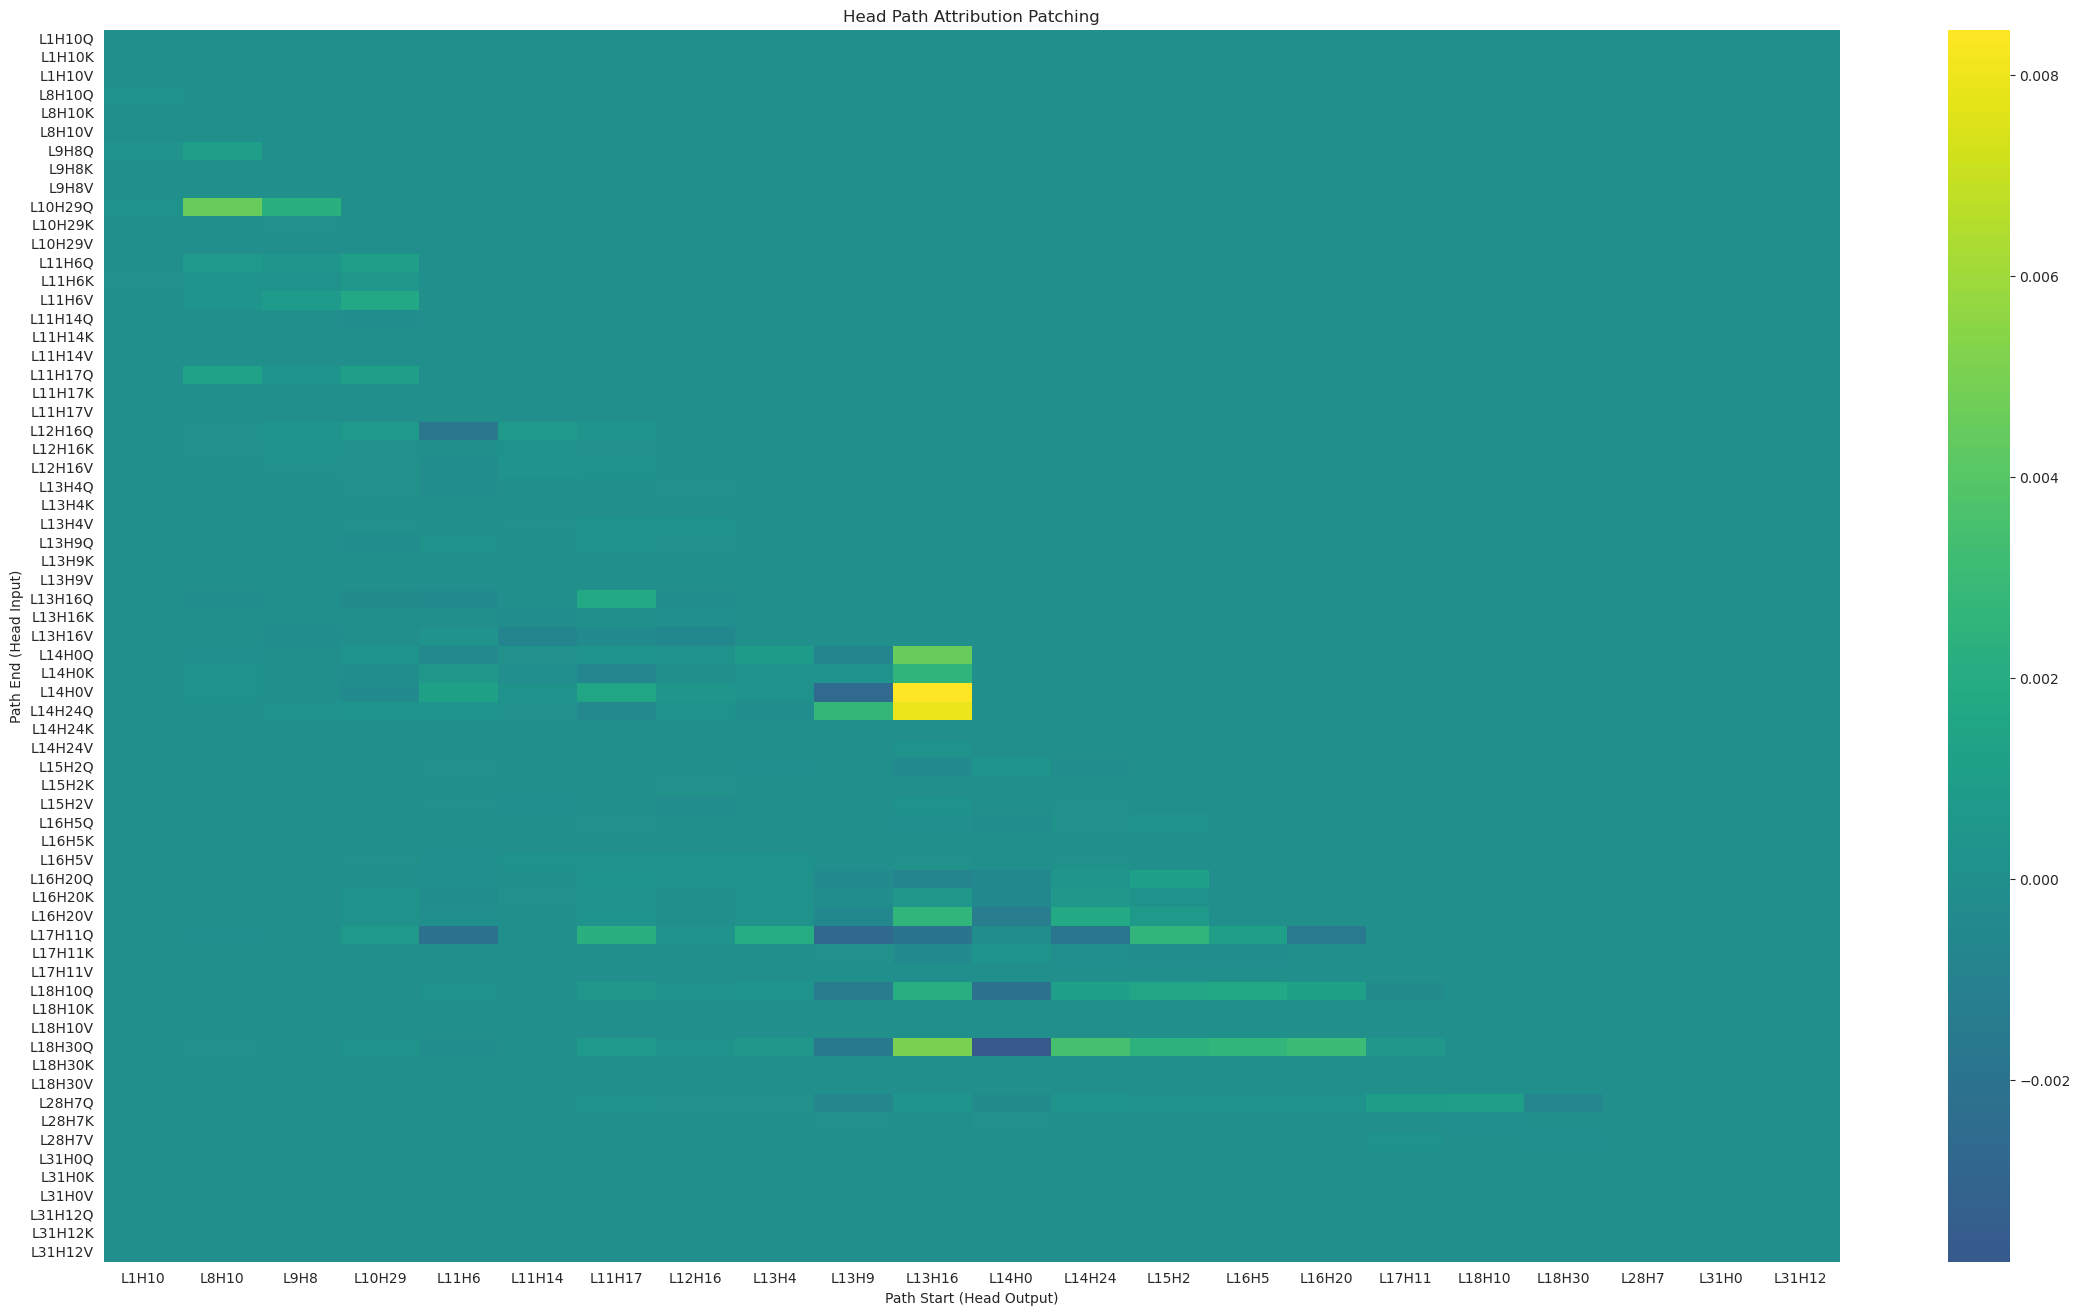

In [37]:
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

plt.plot(head_out_values.detach().numpy())

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)

check_gpu_memory()

plt.figure(figsize=(28, 16))
sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1).detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
plt.show()


## Validating Attribution vs Activation

## Logit difference 

In [25]:
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 44736.94 MB  Reserved: 46054.00 MB
GPU 1: 81050.62 MB  Allocated: 44765.32 MB  Reserved: 46114.00 MB


In [18]:

# model.to("cpu")
print("here")
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
check_gpu_memory()
clean_logits =  clean_logits.to("cpu")
clean_cache = clean_cache.to("cpu")
check_gpu_memory()

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
check_gpu_memory()
corrupted_logits =  corrupted_logits.to("cpu")
corrupted_cache = corrupted_cache.to("cpu")
check_gpu_memory()

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
check_gpu_memory()

here
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 33568.92 MB  Reserved: 33720.00 MB
GPU 1: 81050.62 MB  Allocated: 33628.55 MB  Reserved: 33774.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 28959.62 MB  Reserved: 30264.00 MB
GPU 1: 81050.62 MB  Allocated: 28973.24 MB  Reserved: 30264.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 49342.86 MB  Reserved: 49530.00 MB
GPU 1: 81050.62 MB  Allocated: 49417.25 MB  Reserved: 49624.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 44736.94 MB  Reserved: 46054.00 MB
GPU 1: 81050.62 MB  Allocated: 44765.32 MB  Reserved: 46114.00 MB
Clean logit diff: 0.7750
Corrupted logit diff: -0.5336
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 44736.94 MB  Reserved: 46054.00 MB
GPU 1: 81050.62 MB  Allocated: 44765.32 MB  Reserved: 46114.00 MB


In [24]:
answer_token_indices.shape

torch.Size([6, 2])

In [19]:
clean_logits.shape

torch.Size([6, 72, 32016])

In [14]:
# IOI metric - does this mean indirect object identification? Yes

CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff

def ioi_metric(logits, answer_token_indices=answer_token_indices):
    logits = logits.to(device)
    torch.cuda.empty_cache()
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")
check_gpu_memory()

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34222.14 MB  Reserved: 35164.00 MB
GPU 1: 81050.62 MB  Allocated: 34238.98 MB  Reserved: 35126.00 MB


In [15]:
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]

## Removing prev cache
The memory shot up during run_with_cache, which I dont think we need later on

In [16]:
# Delete tensors
del clean_logits
del corrupted_logits
del clean_logit_diff 
del corrupted_logit_diff
clean_cache = clean_cache.to("cpu")
del corrupted_cache

# Empty CUDA cache
torch.cuda.empty_cache()

# Optionally check memory to confirm
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 13182.31 MB  Reserved: 13338.00 MB
GPU 1: 81050.62 MB  Allocated: 13182.43 MB  Reserved: 13338.00 MB


# Attribution patching

In [17]:
filter_not_qkv_input = lambda name: "_input" not in name

def get_cache_fwd_and_bwd(model, tokens, metric):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")
    grad_cache = {}

    def backward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        grad_cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")
    
    result = model(tokens).to(device)
    torch.cuda.empty_cache()
    value = metric(result)
    value.backward()

    # Reset hooks and clear unused GPU memory
    value = value.item()
    model.reset_hooks()
    torch.cuda.empty_cache()
    
    cache = ActivationCache(cache, model).to(device)
    grad_cache = ActivationCache(grad_cache, model).to(device)
    
    return value, cache, grad_cache

clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, clean_tokens, ioi_metric)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
print("Clean Gradients Cached:", len(clean_grad_cache))
check_gpu_memory()

clean_cache = clean_cache.to('cpu')
clean_grad_cache = clean_grad_cache.to('cpu')

check_gpu_memory()

corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, corrupted_tokens, ioi_metric)
print("Corrupted Value:", corrupted_value)
print("Corrupted Activations Cached:", len(corrupted_cache))
print("Corrupted Gradients Cached:", len(corrupted_grad_cache))
check_gpu_memory()

corrupted_cache = corrupted_cache.to('cpu')
corrupted_grad_cache = corrupted_grad_cache.to('cpu')

torch.cuda.empty_cache()
check_gpu_memory()

Clean Value: 1.0
Clean Activations Cached: 739
Clean Gradients Cached: 739
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 57531.98 MB  Reserved: 58264.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB
Corrupted Value: 0.0
Corrupted Activations Cached: 739
Corrupted Gradients Cached: 739
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 57526.73 MB  Reserved: 58226.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


In [51]:
clean_cache['hook_embed'].shape

torch.Size([4, 72, 4096])

In [18]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']


In [19]:
@timeit
def create_attention_attr(
    clean_cache, clean_grad_cache, device
) -> TT["batch", "layer", "head_index", "dest", "src"]:
    attention_stack = torch.stack(
        [clean_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_grad_stack = torch.stack(
        [clean_grad_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_attr = attention_grad_stack * attention_stack
    attention_attr = einops.rearrange(
        attention_attr,
        "layer batch head_index dest src -> batch layer head_index dest src",
    )
    return attention_attr

attention_attr = create_attention_attr(clean_cache, clean_grad_cache, "cpu")
check_gpu_memory()

Function 'create_attention_attr' executed in 0.0726 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


In [20]:
torch.cuda.empty_cache()
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


# Residual Stream Patching

In [21]:
@timeit
def attr_patch_residual(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device,
) -> TT["component", "pos"]:
    clean_residual, residual_labels = clean_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=True
    )
    corrupted_residual = corrupted_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    corrupted_grad_residual = corrupted_grad_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    residual_attr = einops.reduce(
        corrupted_grad_residual * (clean_residual - corrupted_residual),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return residual_attr, residual_labels

In [22]:
residual_attr, residual_labels = attr_patch_residual(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_residual' executed in 0.3837 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


In [24]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.2 MB/s eta 0:00:00a 0:00:01


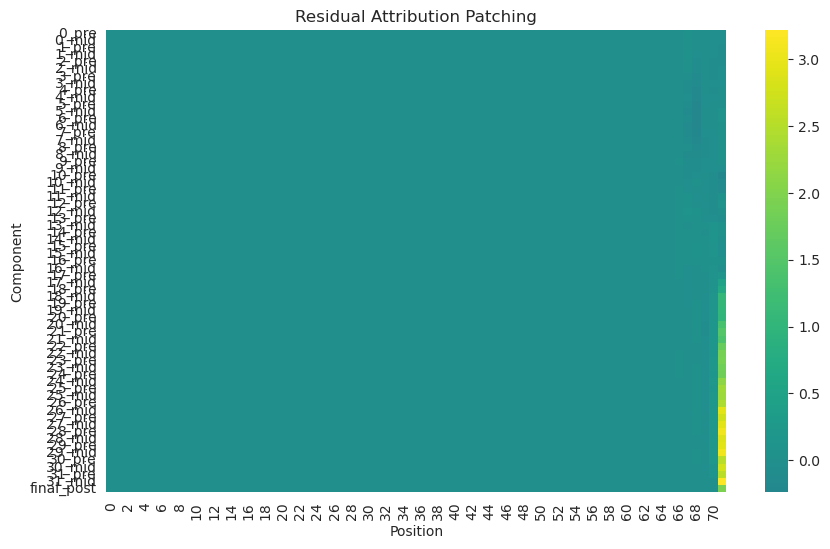

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the background to white
sns.set_style("white")

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residual_attr.detach().numpy(), yticklabels=residual_labels, annot=False, cmap='viridis', center=0)

plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Residual Attribution Patching')
plt.show()

# Layer Output Attribution Patching

In [27]:
@timeit
def attr_patch_layer_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    clean_layer_out, labels = clean_cache.decompose_resid(-1, return_labels=True)
    corrupted_layer_out = corrupted_cache.decompose_resid(-1, return_labels=False)
    corrupted_grad_layer_out = corrupted_grad_cache.decompose_resid(
        -1, return_labels=False
    )
    layer_out_attr = einops.reduce(
        corrupted_grad_layer_out * (clean_layer_out - corrupted_layer_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return layer_out_attr, labels

In [28]:
layer_out_attr, layer_out_labels = attr_patch_layer_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)
check_gpu_memory()

Function 'attr_patch_layer_out' executed in 0.4354 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


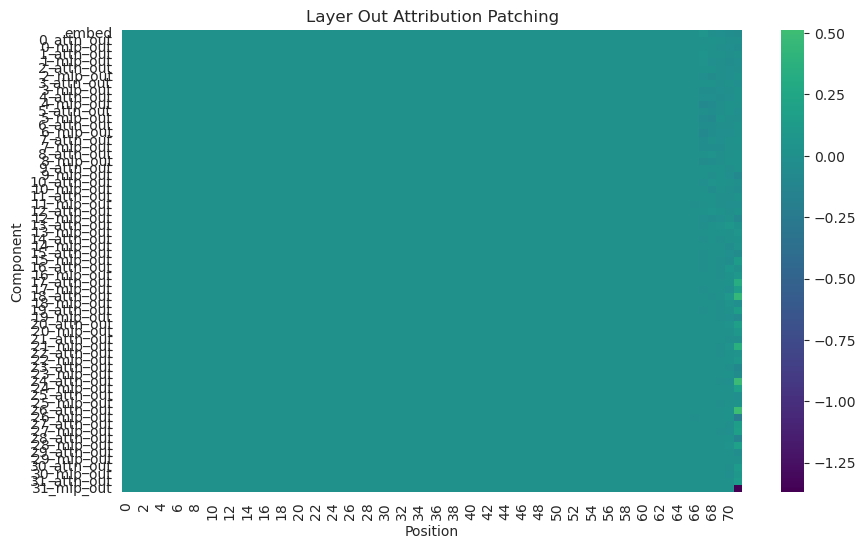

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(layer_out_attr.detach().numpy(), yticklabels=layer_out_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Layer Out Attribution Patching')
plt.show()

# Head output attribution Patching

In [30]:
@timeit
def attr_patch_head_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_out = clean_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_head_out = corrupted_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_grad_head_out = corrupted_grad_cache.stack_head_results(
        -1, return_labels=False
    ).to(device)
    head_out_attr = einops.reduce(
        corrupted_grad_head_out * (clean_head_out - corrupted_head_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return head_out_attr, labels

In [31]:
head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
check_gpu_memory()

Function 'attr_patch_head_out' executed in 5.9244 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26044.61 MB  Reserved: 26224.00 MB
GPU 1: 81050.62 MB  Allocated: 26044.85 MB  Reserved: 26158.00 MB


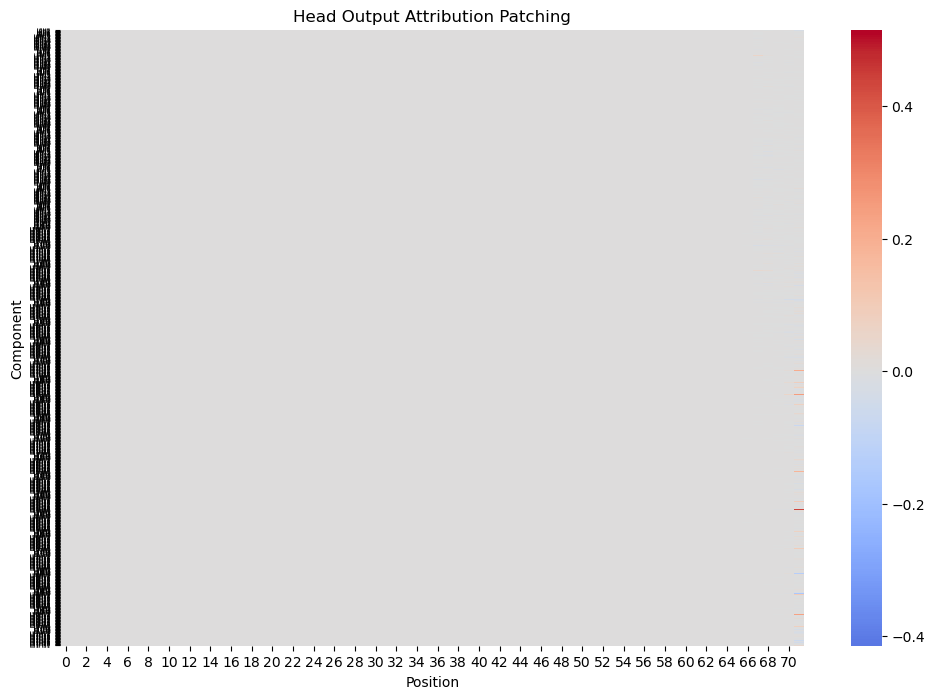

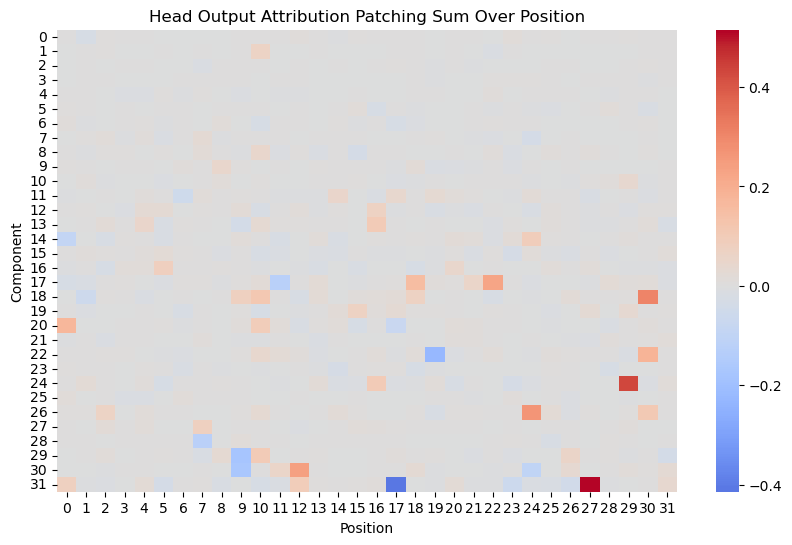

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(head_out_attr.detach().numpy(), yticklabels=head_out_labels, annot=False, cmap='coolwarm', center=0)
plt.yticks(fontsize = 4)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(sum_head_out_attr.detach().numpy(), annot=False, cmap='coolwarm', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching Sum Over Position')
plt.show()

# Head activation patching, skipping it for now

In [30]:
def stack_head_vector_from_cache(
    cache, activation_name: Literal["q", "k", "v", "z"], device
) -> TT["layer_and_head_index", "batch", "pos", "d_head"]:
    """Stacks the head vectors from the cache from a specific activation (key, query, value or mixed_value (z)) into a single tensor."""
    stacked_head_vectors = torch.stack(
        [cache[activation_name, l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_vectors = einops.rearrange(
        stacked_head_vectors,
        "layer batch pos head_index d_head -> (layer head_index) batch pos d_head",
    ).to(device)
    return stacked_head_vectors

@timeit
def attr_patch_head_vector(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    activation_name: Literal["q", "k", "v", "z"],
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_vector = stack_head_vector_from_cache(clean_cache, activation_name, "cpu").to(device)
    corrupted_head_vector = stack_head_vector_from_cache(
        corrupted_cache, activation_name, "cpu"
    ).to(device)
    corrupted_grad_head_vector = stack_head_vector_from_cache(
        corrupted_grad_cache, activation_name, "cpu"
    ).to(device)
    head_vector_attr = einops.reduce(
        corrupted_grad_head_vector * (clean_head_vector - corrupted_head_vector),
        "component batch pos d_head -> component pos",
        "sum",
    )
    return head_vector_attr, labels

In [31]:
head_vector_attr_dict = {}
for activation_name, activation_name_full in [
    ("k", "Key"),
    ("q", "Query"),
    ("v", "Value"),
    ("z", "Mixed Value"),
]:
    head_vector_attr_dict[activation_name], head_vector_labels = attr_patch_head_vector(
        clean_cache, corrupted_cache, corrupted_grad_cache, activation_name, "cpu"
    )
    sum_head_vector_attr = einops.reduce(
        head_vector_attr_dict[activation_name],
        "(layer head) pos -> layer head",
        "sum",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()

Function 'attr_patch_head_vector' executed in 0.1752 seconds
Function 'attr_patch_head_vector' executed in 0.1506 seconds
Function 'attr_patch_head_vector' executed in 0.1564 seconds
Function 'attr_patch_head_vector' executed in 0.1737 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


# Head Pattern Attribution Patching

In [32]:
def stack_head_pattern_from_cache(
    cache,
    device
) -> TT["layer_and_head_index", "batch", "dest_pos", "src_pos"]:
    """Stacks the head patterns from the cache into a single tensor."""
    stacked_head_pattern = torch.stack(
        [cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_pattern = einops.rearrange(
        stacked_head_pattern,
        "layer batch head_index dest_pos src_pos -> (layer head_index) batch dest_pos src_pos",
    ).to(device)
    return stacked_head_pattern

@timeit
def attr_patch_head_pattern(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "dest_pos", "src_pos"]:
    labels = HEAD_NAMES

    clean_head_pattern = stack_head_pattern_from_cache(clean_cache, "cpu").to(device)
    corrupted_head_pattern = stack_head_pattern_from_cache(corrupted_cache, "cpu").to(device)
    corrupted_grad_head_pattern = stack_head_pattern_from_cache(corrupted_grad_cache, "cpu").to(device)
    head_pattern_attr = einops.reduce(
        corrupted_grad_head_pattern * (clean_head_pattern - corrupted_head_pattern),
        "component batch dest_pos src_pos -> component dest_pos src_pos",
        "sum",
    ).to(device)
    return head_pattern_attr, labels

In [33]:
head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

head_pattern_attr = einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()

Function 'attr_patch_head_pattern' executed in 0.0454 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


# Head Path Attribution Patching

In [34]:
def get_head_vector_grad_input_from_grad_cache(
    grad_cache: ActivationCache, activation_name: Literal["q", "k", "v"], layer: int, device
) -> TT["batch", "pos", "head_index", "d_model"]:
    vector_grad = grad_cache[activation_name, layer].to(device)
    ln_scales = grad_cache["scale", layer, "ln1"].to(device)
    attn_layer_object = model.blocks[layer].attn
    if activation_name == "q":
        W = attn_layer_object.W_Q.to(device)
    elif activation_name == "k":
        W = attn_layer_object.W_K.to(device)
    elif activation_name == "v":
        W = attn_layer_object.W_V.to(device)
    else:
        raise ValueError("Invalid activation name")

    # Original notebook used (batch pos) for second input but that seems to be wrong - double check this computation
    return einsum(
        "batch pos head_index d_head, batch pos head_index, head_index d_model d_head -> batch pos head_index d_model",
        vector_grad,
        ln_scales.squeeze(-1),
        W,
    )

def get_stacked_head_vector_grad_input(
    grad_cache, activation_name: Literal["q", "k", "v"], device
) -> TT["layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_head_vector_grad_input_from_grad_cache(grad_cache, activation_name, l, "cpu")
            for l in range(model.cfg.n_layers)
        ],
        dim=0,
    ).to(device)

def get_full_vector_grad_input(
    grad_cache, device
) -> TT["qkv", "layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack([get_stacked_head_vector_grad_input(grad_cache, activation_name, "cpu").to(device) for activation_name in ["q", "k", "v"]], dim=0).to(device)

@timeit
def attr_patch_head_path(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["qkv", "dest_component", "src_component", "pos"]:
    """
    Computes the attribution patch along the path between each pair of heads.

    Sets this to zero for the path from any late head to any early head

    """
    start_labels = HEAD_NAMES
    end_labels = HEAD_NAMES_QKV
    full_vector_grad_input = get_full_vector_grad_input(corrupted_grad_cache, "cpu")
    clean_head_result_stack = clean_cache.stack_head_results(-1)
    corrupted_head_result_stack = corrupted_cache.stack_head_results(-1)
    diff_head_result = einops.rearrange(
        clean_head_result_stack - corrupted_head_result_stack,
        "(layer head_index) batch pos d_model -> layer batch pos head_index d_model",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    path_attr = einsum(
        "qkv layer_end batch pos head_end d_model, layer_start batch pos head_start d_model -> qkv layer_end head_end layer_start head_start pos",
        full_vector_grad_input,
        diff_head_result,
    )
    correct_layer_order_mask = (
        torch.arange(model.cfg.n_layers)[None, :, None, None, None, None]
        > torch.arange(model.cfg.n_layers)[None, None, None, :, None, None]
    ).to(path_attr.device)
    zero = torch.zeros(1, device=path_attr.device)
    path_attr = torch.where(correct_layer_order_mask, path_attr, zero)

    path_attr = einops.rearrange(
        path_attr,
        "qkv layer_end head_end layer_start head_start pos -> (layer_end head_end qkv) (layer_start head_start) pos",
    )
    return path_attr, end_labels, start_labels


In [35]:
head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache, corrupted_cache, corrupted_grad_cache, "cpu"
)

Function 'attr_patch_head_path' executed in 32.3859 seconds


In [36]:
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


In [37]:
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])
        
top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)

check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


In [38]:
interesting_heads = [
    5 * model.cfg.n_heads + 5,
    8 * model.cfg.n_heads + 6,
    9 * model.cfg.n_heads + 9,
]
interesting_head_labels = [HEAD_NAMES[i] for i in interesting_heads]
for head_index, label in zip(interesting_heads, interesting_head_labels):
    in_paths = head_path_attr[3 * head_index : 3 * head_index + 3].sum(-1)
    out_paths = head_path_attr[:, head_index].sum(-1)
    out_paths = einops.rearrange(out_paths, "(layer_head qkv) -> qkv layer_head", qkv=3)
    all_paths = torch.cat([in_paths, out_paths], dim=0)
    all_paths = einops.rearrange(
        all_paths,
        "path_type (layer head) -> path_type layer head",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
    # TODO - implement visualization for input/output paths per head
    
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


# Validating Attribution vs Activation Patching

In [45]:
attribution_cache_dict = {}
for key in corrupted_grad_cache.cache_dict.keys():
    attribution_cache_dict[key] = corrupted_grad_cache.cache_dict[key] * (
        clean_cache.cache_dict[key] - corrupted_cache.cache_dict[key]
    ).to("cpu")
attr_cache = ActivationCache(attribution_cache_dict, model).to("cpu")
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


# Activation Patching per Block, skipping it for now

In [16]:
device

'cuda:0'

In [17]:
str_tokens = model.to_str_tokens(clean_tokens[0])
context_length = len(str_tokens)
every_block_act_patch_result = patching.get_act_patch_block_every(
    model, corrupted_tokens, clean_cache, ioi_metric
).to("cpu")

check_gpu_memory()

Moving model to device:  cuda:0


  0%|          | 0/544 [00:00<?, ?it/s]

  0%|          | 0/544 [00:00<?, ?it/s]

  0%|          | 0/544 [00:00<?, ?it/s]

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 34368.80 MB  Reserved: 34416.00 MB


# Attribution Patching per Block

In [42]:
@timeit
def get_attr_patch_block_every(attr_cache, device):
    resid_pre_attr = einops.reduce(
        attr_cache.stack_activation("resid_pre"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)
    attn_out_attr = einops.reduce(
        attr_cache.stack_activation("attn_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)
    mlp_out_attr = einops.reduce(
        attr_cache.stack_activation("mlp_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    ).to(device)

    every_block_attr_patch_result = torch.stack(
        [resid_pre_attr, attn_out_attr, mlp_out_attr], dim=0
    )
    return every_block_attr_patch_result

In [43]:
every_block_attr_patch_result = get_attr_patch_block_every(attr_cache, "cpu")
check_gpu_memory()

Function 'get_attr_patch_block_every' executed in 0.0838 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.20 MB  Reserved: 52136.00 MB


# Activation Patching per Head

In [18]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

# Attribution Patching per Head

In [44]:
@timeit
def get_attr_patch_attn_head_all_pos_every(attr_cache, device):
    head_out_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_q_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_k_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_v_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_pattern_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer head_index",
        "sum",
    )

    return torch.stack(
        [
            head_out_all_pos_attr,
            head_q_all_pos_attr,
            head_k_all_pos_attr,
            head_v_all_pos_attr,
            head_pattern_all_pos_attr,
        ]
    )


every_head_all_pos_attr_patch_result = get_attr_patch_attn_head_all_pos_every(
    attr_cache, "cpu"
)

Function 'get_attr_patch_attn_head_all_pos_every' executed in 0.1443 seconds


In [ ]:
every_head_by_pos_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(
    model, corrupted_tokens, clean_cache, ioi_metric
)
every_head_by_pos_act_patch_result = einops.rearrange(
    every_head_by_pos_act_patch_result,
    "act_type layer pos head -> act_type (layer head) pos",
)